In [72]:
from jupyterthemes import jtplot
jtplot.style(theme='solarizedl', context='notebook', ticks=True, grid=False, figsize=(10,6))

In [69]:
import numpy as np
import pandas as pd
from datetime import datetime
from collections import OrderedDict, defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary as summary_
import torchvision
import torchvision.transforms as transforms

import data_loader
import utils
import calibration
import train as t

In [51]:
import calibration
uniform_calib_mean = calibration.CalibrationLoss()
uniform_calib_max = calibration.CalibrationLoss(func='max')
quantile_calib_mean = calibration.CalibrationLoss(strategy='quantile')
quantile_calib_max = calibration.CalibrationLoss(strategy='quantile', func='max')

In [98]:
trainloader, validloader = data_loader.get_train_valid_loader(data_dir='./data',
                           batch_size=512,
                           augment=True,
                           random_seed=42,
                           valid_size=0.1,
                           shuffle=False,
                           show_sample=False,
                           num_workers=4,
                           pin_memory=False)

Files already downloaded and verified
Files already downloaded and verified


In [41]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
criterion = nn.CrossEntropyLoss()

Using cache found in /home/hyunsikkim/.cache/torch/hub/pytorch_vision_v0.10.0


In [42]:
def load_model(modelname, model_path) : 
    model = torch.hub.load('pytorch/vision:v0.10.0', modelname, pretrained=True)
    hidden_size = model.fc.weight.shape[1]
    model.fc = nn.Linear(hidden_size, len(utils.label_names))

    state_dict = torch.load(model_path)
    adj_state_dict = OrderedDict()
    for k,v in state_dict.items() : 
        adj_state_dict[k.replace("module.",'')] = v

    model.load_state_dict(adj_state_dict)
    model = model.eval().to(device)
    return model

In [99]:
model = load_model('resnet18', 'models/resnet18.20211121.pt')
model = model.eval()

Using cache found in /home/hyunsikkim/.cache/torch/hub/pytorch_vision_v0.10.0


In [100]:
def inference(testloader, device, model, criterion) : 
    umean_container = list()
    umax_container = list()
    qmean_container = list()
    qmax_container = list()
    loss_container = list()
    acc_container = list()
    model.eval()
    for inputs, labels in testloader :

        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        predictions = outputs.argmax(1)
        acc = (outputs.argmax(1).eq(labels).sum() / outputs.shape[0]).item()

        loss = criterion(outputs, labels)

        loss_container.append(loss.item())
        acc_container.append(acc)

        prob, true = torch.softmax(outputs, dim=1).cpu().data.numpy(), labels.cpu().data.numpy()

        ece = uniform_calib_mean.calculate_ce(prob, true)
        umean_container.append(ece)

        ece = uniform_calib_max.calculate_ce(prob, true)
        umax_container.append(ece)

        ece = quantile_calib_mean.calculate_ce(prob, true)
        qmean_container.append(ece)

        ece = quantile_calib_max.calculate_ce(prob, true)
        qmax_container.append(ece)

    test_loss = np.mean(loss_container)
    test_acc = np.mean(acc_container)
    test_umean = np.mean(umean_container)
    test_umax = np.mean(umax_container)
    test_qmean = np.mean(qmean_container)
    test_qmax = np.mean(qmax_container)
    
    return test_loss, test_acc, test_umean, test_umax, test_qmean, test_qmax

In [101]:
pretrained_weight = model.fc.weight.clone()
container = list()

for i in range(0,10+1) : 
    
    ts_coef_ = 1+i/10
    
    with torch.no_grad():
        model.fc.weight = nn.Parameter(pretrained_weight)

    with torch.no_grad():
        model.fc.weight = nn.Parameter(model.fc.weight/ts_coef_)
        
    loss, acc, umean, umax, qmean, qmax = inference(validloader, device, model, criterion)
    container.append((loss, acc, umean, umax, qmean, qmax))

In [102]:
df = pd.DataFrame(container, columns=['loss', 'acc', 'umean', 'umax', 'qmean', 'qmax'], index=[1+i/10 for i in range(0,10+1)])

<AxesSubplot:>

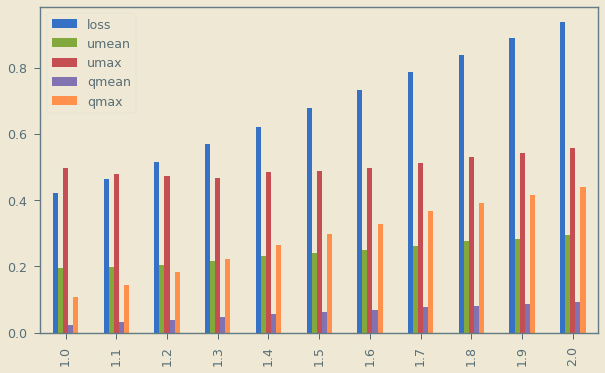

In [109]:
df.iloc[:,[0,2,3,4,5]].plot.bar() # exclude acc

In [103]:
np.argmin(df.values, axis=0)

array([0, 3, 0, 3, 0, 0])